In [1]:
# Import libraries and set random seeds
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

print("Imported libraries and fixed random seeds.")


Imported libraries and fixed random seeds.


In [2]:
# Load and inspect the orthography dataset
df_ortho = pd.read_csv('orthodata.csv')
print(f"Dataset loaded: {df_ortho.shape[0]} rows, columns: {list(df_ortho.columns)}")
print("First five entries:", df_ortho.head()['words'].tolist())


Dataset loaded: 52447 rows, columns: ['Unnamed: 0', 'words', 'IPA']
First five entries: ['a', 'a', 'a', 'A', 'AA']


In [3]:
# Filter to alphabetic English words of length ≥2 and deduplicate
all_words = df_ortho['words'].dropna().astype(str).str.lower()
alpha_words = [w for w in all_words if w.isalpha() and len(w) >= 2]
print(f"Kept {len(alpha_words)} alphabetic words ≥2 chars (with duplicates).")

unique_words = list(set(alpha_words))
print(f"After deduplication: {len(unique_words)} unique words.")


Kept 48108 alphabetic words ≥2 chars (with duplicates).
After deduplication: 41703 unique words.


In [4]:
# Build character vocabulary (including start/end tokens)
char_set = set(''.join(unique_words))
char_set.update(['<s>', '</s>'])
vocab_chars = sorted(char_set)

char_to_idx = {ch: i for i, ch in enumerate(vocab_chars)}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}

print(f"Vocabulary of {len(vocab_chars)} characters built.")


Vocabulary of 28 characters built.


In [5]:
# Create CBOW training examples (context→target)
context_size = 3
contexts, targets = [], []

for word in unique_words:
    padded = ['<s>']*context_size + list(word) + ['</s>']*context_size
    for i in range(context_size, len(padded)-context_size):
        left  = padded[i-context_size:i]
        right = padded[i+1:i+1+context_size]
        ctx   = left + right
        tgt   = padded[i]
        contexts.append([char_to_idx[c] for c in ctx])
        targets.append(char_to_idx[tgt])

contexts = np.array(contexts, dtype=np.int64)
targets  = np.array(targets,  dtype=np.int64)
print(f"Created {len(targets)} training examples.")
print("Example context indices:", contexts[0], "→ target index:", targets[0])


Created 353662 training examples.
Example context indices: [ 1  1  1  6  2 19] → target index: 9


In [6]:
# Wrap data into DataLoaders (90% train / 10% validation)
batch_size = 256

tensor_ctx = torch.tensor(contexts, dtype=torch.long)
tensor_tgt = torch.tensor(targets, dtype=torch.long)
dataset    = TensorDataset(tensor_ctx, tensor_tgt)

split = int(len(dataset)*0.9)
train_ds = torch.utils.data.Subset(dataset, list(range(split)))
valid_ds = torch.utils.data.Subset(dataset, list(range(split, len(dataset))))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size)

print(f"Train batches: {len(train_loader)}, Validation batches: {len(valid_loader)}")


Train batches: 1244, Validation batches: 139


In [7]:
# Initialize embedding-based CBOW model and optimizer
vocab_size    = len(char_to_idx)
embed_dim     = 50
hidden_dim    = 128

embed_layer = nn.Embedding(vocab_size, embed_dim)
fc1_layer   = nn.Linear(2*context_size*embed_dim, hidden_dim)
relu        = nn.ReLU()
dropout     = nn.Dropout(0.2)
fc2_layer   = nn.Linear(hidden_dim, vocab_size)

criterion   = nn.CrossEntropyLoss()
optimizer   = optim.Adam(
    list(embed_layer.parameters()) +
    list(fc1_layer.parameters()) +
    list(fc2_layer.parameters()),
    lr=1e-3
)

print("Model and optimizer set up:")
print(" ", embed_layer)
print(" ", fc1_layer, "→", relu, "→", dropout, "→", fc2_layer)


Model and optimizer set up:
  Embedding(28, 50)
  Linear(in_features=300, out_features=128, bias=True) → ReLU() → Dropout(p=0.2, inplace=False) → Linear(in_features=128, out_features=28, bias=True)


In [8]:
# Training loop: train & validate over epochs
num_epochs = 15
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs+1):
    # Training phase
    embed_layer.train(); fc1_layer.train(); fc2_layer.train()
    running_train = 0.0
    for ctx_batch, tgt_batch in tqdm(train_loader, desc=f"Epoch {epoch} training"):
        optimizer.zero_grad()
        embeds = embed_layer(ctx_batch).view(ctx_batch.size(0), -1)
        hidden = relu(fc1_layer(embeds))
        hidden = dropout(hidden)
        logits = fc2_layer(hidden)
        loss   = criterion(logits, tgt_batch)
        loss.backward()
        optimizer.step()
        running_train += loss.item() * ctx_batch.size(0)
    avg_train = running_train / len(train_ds)
    train_losses.append(avg_train)

    # Validation phase
    embed_layer.eval(); fc1_layer.eval(); fc2_layer.eval()
    running_valid = 0.0
    with torch.no_grad():
        for ctx_batch, tgt_batch in valid_loader:
            embeds = embed_layer(ctx_batch).view(ctx_batch.size(0), -1)
            hidden = relu(fc1_layer(embeds))
            hidden = dropout(hidden)
            logits = fc2_layer(hidden)
            running_valid += criterion(logits, tgt_batch).item() * ctx_batch.size(0)
    avg_valid = running_valid / len(valid_ds)
    valid_losses.append(avg_valid)

    print(f"Epoch {epoch}: train_loss={avg_train:.4f}, valid_loss={avg_valid:.4f}")


Epoch 1 training: 100%|███████████████████████████████████████████████████████████████████| 1244/1244 [00:17<00:00, 72.79it/s]


Epoch 1: train_loss=1.9252, valid_loss=1.7649


Epoch 2 training: 100%|███████████████████████████████████████████████████████████████████| 1244/1244 [00:16<00:00, 73.25it/s]


Epoch 2: train_loss=1.6929, valid_loss=1.6907


Epoch 3 training: 100%|███████████████████████████████████████████████████████████████████| 1244/1244 [00:17<00:00, 71.27it/s]


Epoch 3: train_loss=1.6354, valid_loss=1.6612


Epoch 4 training: 100%|███████████████████████████████████████████████████████████████████| 1244/1244 [00:18<00:00, 67.12it/s]


Epoch 4: train_loss=1.6051, valid_loss=1.6393


Epoch 5 training: 100%|███████████████████████████████████████████████████████████████████| 1244/1244 [00:18<00:00, 68.90it/s]


Epoch 5: train_loss=1.5836, valid_loss=1.6284


Epoch 6 training: 100%|███████████████████████████████████████████████████████████████████| 1244/1244 [00:17<00:00, 69.74it/s]


Epoch 6: train_loss=1.5700, valid_loss=1.6162


Epoch 7 training: 100%|███████████████████████████████████████████████████████████████████| 1244/1244 [00:18<00:00, 68.76it/s]


Epoch 7: train_loss=1.5588, valid_loss=1.6072


Epoch 8 training: 100%|███████████████████████████████████████████████████████████████████| 1244/1244 [00:18<00:00, 68.33it/s]


Epoch 8: train_loss=1.5502, valid_loss=1.6012


Epoch 9 training: 100%|███████████████████████████████████████████████████████████████████| 1244/1244 [00:16<00:00, 74.22it/s]


Epoch 9: train_loss=1.5412, valid_loss=1.5999


Epoch 10 training: 100%|██████████████████████████████████████████████████████████████████| 1244/1244 [00:18<00:00, 69.06it/s]


Epoch 10: train_loss=1.5341, valid_loss=1.5984


Epoch 11 training: 100%|██████████████████████████████████████████████████████████████████| 1244/1244 [00:16<00:00, 74.17it/s]


Epoch 11: train_loss=1.5295, valid_loss=1.5884


Epoch 12 training: 100%|██████████████████████████████████████████████████████████████████| 1244/1244 [00:18<00:00, 68.20it/s]


Epoch 12: train_loss=1.5253, valid_loss=1.5920


Epoch 13 training: 100%|██████████████████████████████████████████████████████████████████| 1244/1244 [00:18<00:00, 68.08it/s]


Epoch 13: train_loss=1.5210, valid_loss=1.5841


Epoch 14 training: 100%|██████████████████████████████████████████████████████████████████| 1244/1244 [00:18<00:00, 67.35it/s]


Epoch 14: train_loss=1.5185, valid_loss=1.5835


Epoch 15 training: 100%|██████████████████████████████████████████████████████████████████| 1244/1244 [00:18<00:00, 68.10it/s]


Epoch 15: train_loss=1.5155, valid_loss=1.5823


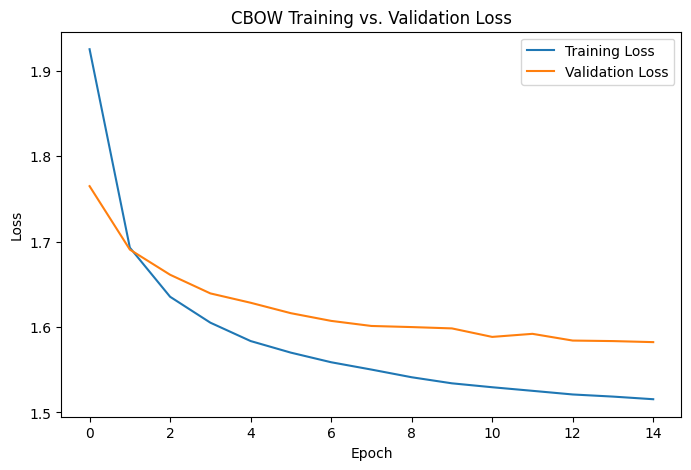

In [9]:
# Plot training and validation loss curves
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CBOW Training vs. Validation Loss')
plt.legend()
plt.show()


In [10]:
# Generate five words starting with 't' by sampling from the model
print("Generated words beginning with 't':")
for i in range(5):
    generated = ['t']
    context_buf = ['<s>']*context_size + ['t']
    for _ in range(15):
        ctx_tokens = context_buf[-context_size:] + context_buf[-context_size:]
        ctx_tensor = torch.tensor([[char_to_idx[ch] for ch in ctx_tokens]], dtype=torch.long)
        with torch.no_grad():
            logits = fc2_layer(dropout(relu(fc1_layer(embed_layer(ctx_tensor).view(1, -1)))))
            probs  = torch.softmax(logits, dim=1)
            idx    = torch.multinomial(probs[0], 1).item()
        char = idx_to_char[idx]
        if char == '</s>': break
        generated.append(char)
        context_buf.append(char)
    print(" ", "".join(generated))


Generated words beginning with 't':
  tordforbeelmseri
  theacherchunbory
  talimplosivitipa
  togotseneconsper
  taragfluteaurjou
